# 4D-STEM single-frame noise test (RAM-friendly)
This notebook loads **one** diffraction pattern from a 4D-STEM dataset, adds detector-like noise (Poisson + PSF blur + dark current + readout), and plots **original / noisy / difference**.


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import hyperspy.api as hs
from scipy.ndimage import gaussian_filter
from typing import Optional

from abc import ABC, abstractmethod
from typing import Any, Dict, Optional, Tuple, List


In [4]:
# ============================================================================
# Noise models (minimal set used by the final plot)
# ============================================================================

class NoiseModel(ABC):
    @abstractmethod
    def apply(self, data: np.ndarray, **kwargs) -> np.ndarray:
        raise NotImplementedError


class PoissonNoise(NoiseModel):
    """Shot noise (Poisson), optionally blurred by detector PSF (Gaussian)."""

    def apply(self, data: np.ndarray, scale: float = 1.0, psf_sigma: float = 0.0) -> np.ndarray:
        # Poisson expects non-negative intensities
        scaled = np.clip(data, 0, None) * scale
        noisy = np.random.poisson(scaled).astype(np.float32)

        # Optional detector PSF blur
        if psf_sigma and psf_sigma > 0:
            noisy = gaussian_filter(noisy, sigma=psf_sigma, mode="nearest")

        return noisy / scale


class DarkCurrentNoise(NoiseModel):
    """Dark current (Poisson-distributed counts)."""

    def apply(self, data: np.ndarray, dark_current: float = 1.0) -> np.ndarray:
        dark = np.random.poisson(dark_current, data.shape).astype(np.float32, copy=False)
        return data + dark


class ReadoutNoise(NoiseModel):
    """Readout noise (additive Gaussian, in counts)."""

    def apply(self, data: np.ndarray, sigma: float = 5.0) -> np.ndarray:
        noise = np.random.normal(0, sigma, data.shape).astype(np.float32, copy=False)
        return data + noise
        
class DrizzleNearBrightPoissonNoise(NoiseModel):
    """
    For the brightest p% pixels, drizzle Poisson-distributed counts onto
    K randomly chosen pixels within a radius (<=radius_px) AND within a square window (square_side x square_side).

    This creates "correlated" salt-like noise near bright features.
    """

    def apply(
        self,
        data: np.ndarray,
        bright_fraction: float = 0.01,     # 1% brightest pixels
        radius_px: int = 5,                # within distance <= 5 pixels
        square_side: int = 10,             # within 10x10 window
        drizzles_per_seed: int = 3,        # drizzle onto 3 pixels per bright seed
        lam_fraction: float = 0.05,        # lambda = lam_fraction * seed_intensity
        lam_min: float = 1.0,              # minimum lambda
        exclude_center: bool = True,       # don't drizzle onto the seed pixel itself
        rng: Optional[np.random.Generator] = None,
    ) -> np.ndarray:
        if rng is None:
            rng = np.random.default_rng()

        img = np.asarray(data, dtype=np.float32, order="C")
        h, w = img.shape

        # --- choose brightest pixels (top bright_fraction) ---
        if not (0.0 < bright_fraction < 1.0):
            raise ValueError("bright_fraction must be in (0,1)")

        thr = np.quantile(img, 1.0 - bright_fraction)
        seeds = np.argwhere(img >= thr)  # array of (y, x)

        if seeds.size == 0:
            return img.copy()

        # --- candidate offsets in a square window, additionally constrained by radius ---
        half = square_side // 2
        # For square_side=10 -> offsets [-5,4] (10 values), matching your 10x10 wording
        ys = np.arange(-half, -half + square_side, dtype=int)
        xs = np.arange(-half, -half + square_side, dtype=int)
        dy, dx = np.meshgrid(ys, xs, indexing="ij")
        dy = dy.ravel()
        dx = dx.ravel()

        # radius constraint
        mask_r = (dy * dy + dx * dx) <= (radius_px * radius_px)
        if exclude_center:
            mask_r &= ~((dy == 0) & (dx == 0))

        dy = dy[mask_r]
        dx = dx[mask_r]
        n_candidates = dy.size
        if n_candidates == 0:
            return img.copy()

        out = img.copy()

        # --- drizzle loop ---
        for (y, x) in seeds:
            seed_intensity = float(img[y, x])
            lam = max(lam_min, lam_fraction * seed_intensity)

            # pick K distinct offsets
            k = min(drizzles_per_seed, n_candidates)
            pick = rng.choice(n_candidates, size=k, replace=False)

            yy = y + dy[pick]
            xx = x + dx[pick]

            # in-bounds
            inb = (yy >= 0) & (yy < h) & (xx >= 0) & (xx < w)
            yy = yy[inb]
            xx = xx[inb]
            if yy.size == 0:
                continue

            # Poisson drizzle counts
            drizzle = rng.poisson(lam, size=yy.size).astype(np.float32)
            out[yy, xx] += drizzle

        return out

def add_noise_to_dp(
    dp: np.ndarray,
    noise_models: List[Tuple[NoiseModel, Dict[str, Any]]],
    seed: Optional[int] = None,
    zero_mean_noise: bool = False,
    clip_negative: bool = False,
) -> np.ndarray:
    """Add noise to a single 2D diffraction pattern (RAM-friendly).

    Parameters
    ----------
    dp : np.ndarray
        2D diffraction pattern (will NOT be modified in-place).
    noise_models : list of (NoiseModel, params_dict)
        Applied sequentially.
    zero_mean_noise : bool
        If True, enforce mean(noisy - original) == 0 for THIS realization.
        Note: clipping negatives will generally break this condition.
    clip_negative : bool
        If True, clamp negative values to 0 after all noise is applied.
    """
    if seed is not None:
        np.random.seed(seed)

    original = np.asarray(dp, dtype=np.float32)
    noisy = original.copy()

    for model, params in noise_models:
        noisy = model.apply(noisy, **params)

    if zero_mean_noise:
        noise = noisy - original
        noise -= noise.mean(dtype=np.float64)
        noisy = original + noise

    if clip_negative:
        noisy = np.maximum(noisy, 0)

    return noisy


def add_realistic_detector_noise_to_dp(
    dp: np.ndarray,
    dose_scale: float,
    psf_sigma: float,
    readout_sigma: float,
    dark_current: float,
    seed: Optional[int] = None,
    zero_mean_noise: bool = False,
    clip_negative: bool = False,
) -> np.ndarray:
    """Poisson (with PSF blur) + dark current + readout noise."""
    models = [
        (PoissonNoise(), {"scale": dose_scale, "psf_sigma": psf_sigma}),
        (DarkCurrentNoise(), {"dark_current": dark_current}),
        (ReadoutNoise(), {"sigma": readout_sigma}),  
        (DrizzleNearBrightPoissonNoise(), {
        "bright_fraction": 0.01,      # 1% brightest
        "radius_px": 10,              # within 5 px
        "square_side": 20,           # 10x10 window
        "drizzles_per_seed": 8,      # 3 pixels per bright seed
        "lam_fraction": 0.05,        # <-- 你最需要调的：滴落强度随 seed 强度的比例
        "lam_min": 1.0,
    }),
    ]
    return add_noise_to_dp(
        dp,
        models,
        seed=seed,
        zero_mean_noise=zero_mean_noise,
        clip_negative=clip_negative,
    )


In [5]:
# ==========================================================
# Get the median and average of the original DP image
# ==========================================================
median_val_dp0 = np.median(dp0)
average_val_dp0 = np.mean(dp0)

print(f"Median of original DP: {median_val_dp0:.4f}")
print(f"Average of original DP: {average_val_dp0:.4f}")


NameError: name 'dp0' is not defined

# ============================================================================
# USER SETTINGS (tune these numbers)
# ============================================================================

In [15]:
# --- File I/O ---
FILEPATH = r"C:\Users\dji\Downloads\4D-STEM_data_for_p-terphenyl\4D-STEM data for p-terphenyl\Mg31258\20220323_160424_data_binned2.hdf5"  # <-- change this
READER = "HSPY"  # <-- try: "HSPY", "Delmic", "USID"

# --- Which scan pixel to preview (navigation position) ---
I0, J0 = 111,113  # <-- change this (scan coordinates)

# --- Noise parameters ---
DOSE_SCALE = 100        # <-- Poisson scale (higher => less relative shot noise, do not set '0')
PSF_SIGMA = 0.8        # <-- Gaussian blur sigma in pixels for PSF (set 0 to disable)
READOUT_SIGMA = 1.0    # <-- Gaussian readout noise (counts)[NEAR AVERAGE OF DP TO SIMULATE MEDIUM LEVEL NOISE
DARK_CURRENT = 1.0     # <-- mean dark current (counts per pixel)

SEED = 1453              # <-- random seed for reproducibility (set None for random)

# --- Constraints / options ---
ZERO_MEAN_NOISE = False   # <-- set True to force mean(noisy - original) == 0 (per DP realization)
CLIP_NEGATIVE = False     # <-- set True to clamp negatives to 0 (breaks ZERO_MEAN_NOISE in general)

# --- Display / plotting ---
VMAX_PERCENTILE = 99.3      # <-- upper percentile for linear imshow
DIFF_SYMM_PERCENTILE = 99.3  # <-- symmetric limits for signed diff (percentile of |diff|) [DECREASE THE NUMBER TO LET IMAGE LOOKS BRIGHTER] 


Loaded shape: (255, 255, 257, 257)
Using scan position (i, j)=(111, 113)


C:\Users\dji\AppData\Local\Temp\ipykernel_2092\3242881219.py:62: RuntimeWarning: invalid value encountered in log1p
  plt.imshow(np.log1p(noisy_dp), vmax=np.percentile(np.log1p(noisy_dp), VMAX_PERCENTILE))


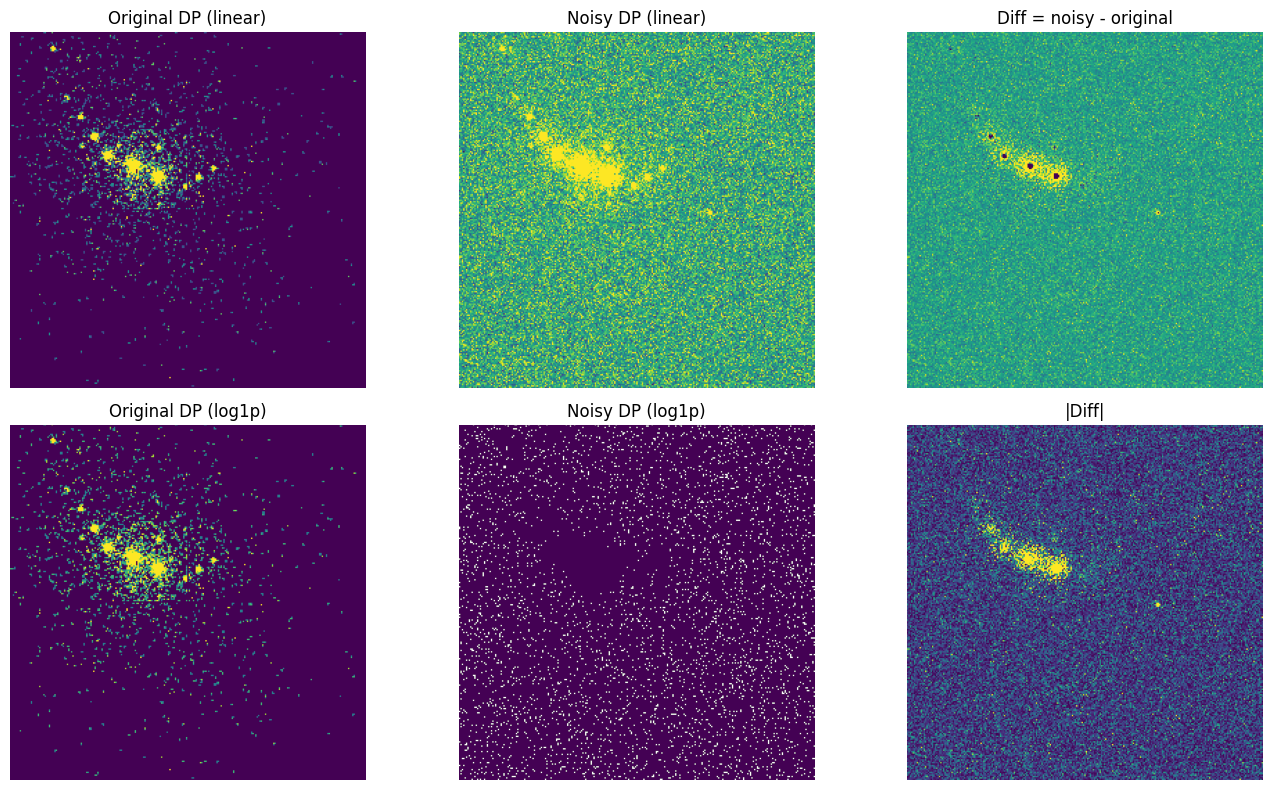

Diff stats: mean= 1.1183514595031738 std= 2.1220083236694336 min= -64.1705322265625 max= 52.78863525390625


In [16]:
# ============================================================================
# Run (RAM-friendly): load ONE DP, add noise, plot results
# ============================================================================

# Load lazily to avoid pulling the full 4D dataset into RAM
s = hs.load(FILEPATH, reader=READER, lazy=True)

scan_i, scan_j, det_i, det_j = s.data.shape
i = min(I0, scan_i - 1)
j = min(J0, scan_j - 1)
print("Loaded shape:", s.data.shape)
print(f"Using scan position (i, j)=({i}, {j})")

# Extract only one diffraction pattern into RAM
dp0 = np.asarray(s.data[i, j, :, :], dtype=np.float32)

# Add realistic detector noise to this single DP
noisy_dp = add_realistic_detector_noise_to_dp(
    dp0,
    dose_scale=DOSE_SCALE,
    psf_sigma=PSF_SIGMA,
    readout_sigma=READOUT_SIGMA,
    dark_current=DARK_CURRENT,
    seed=SEED,
    zero_mean_noise=ZERO_MEAN_NOISE,
    clip_negative=CLIP_NEGATIVE,
)

# Differences
diff = noisy_dp - dp0
absdiff = np.abs(diff)

# Robust display limits
vmax = np.percentile(dp0, VMAX_PERCENTILE)
v = np.percentile(np.abs(diff), DIFF_SYMM_PERCENTILE)
vabs = np.percentile(absdiff, VMAX_PERCENTILE)

# Plot: original / noisy / diff (linear + log)
plt.figure(figsize=(14, 8))

plt.subplot(2, 3, 1)
plt.imshow(dp0, vmax=vmax)
plt.title("Original DP (linear)")
plt.axis("off")

plt.subplot(2, 3, 2)
plt.imshow(noisy_dp, vmax=vmax)
plt.title("Noisy DP (linear)")
plt.axis("off")

plt.subplot(2, 3, 3)
plt.imshow(diff, vmin=-v, vmax=v)
plt.title("Diff = noisy - original")
plt.axis("off")

plt.subplot(2, 3, 4)
plt.imshow(np.log1p(dp0), vmax=np.percentile(np.log1p(dp0), VMAX_PERCENTILE))
plt.title("Original DP (log1p)")
plt.axis("off")

plt.subplot(2, 3, 5)
plt.imshow(np.log1p(noisy_dp), vmax=np.percentile(np.log1p(noisy_dp), VMAX_PERCENTILE))
plt.title("Noisy DP (log1p)")
plt.axis("off")

plt.subplot(2, 3, 6)
plt.imshow(absdiff, vmax=vabs)
plt.title("|Diff|")
plt.axis("off")

plt.tight_layout()
plt.show()

print("Diff stats:",
      "mean=", float(diff.mean()),
      "std=", float(diff.std()),
      "min=", float(diff.min()),
      "max=", float(diff.max()))


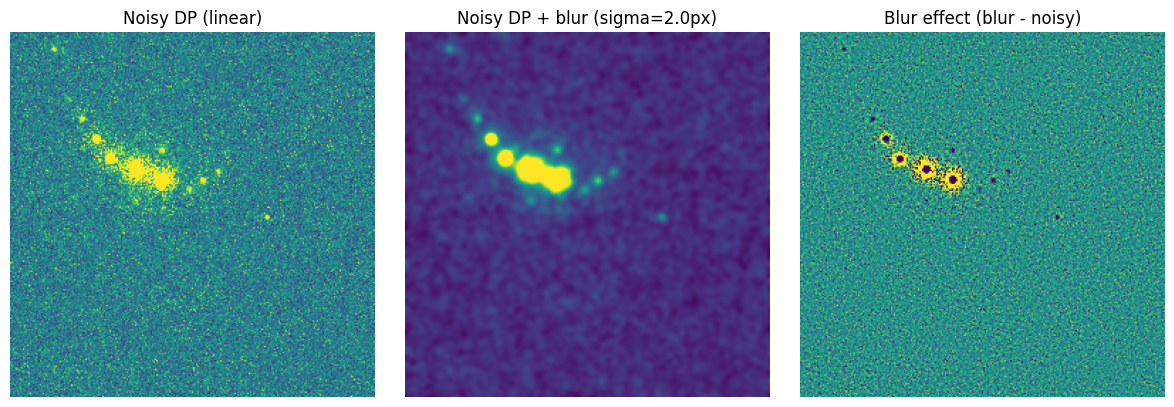

In [17]:
# ==========================================================
# Optional: blur the noisy DP (Gaussian blur, sigma=2 pixels)
# ==========================================================
from scipy.ndimage import gaussian_filter
import numpy as np
import matplotlib.pyplot as plt

# Apply blur on the noisy diffraction pattern
blur_sigma_px = 2.0  # <-- tune this (pixels)
noisy_dp_blur = gaussian_filter(noisy_dp.astype(np.float32, copy=False),
                                sigma=blur_sigma_px, mode="nearest")

# Plot (same robust scaling as before)
vmax_lin = np.percentile(noisy_dp, 99)
vmax_lin_blur = np.percentile(noisy_dp_blur, 99)

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(noisy_dp, vmax=vmax_lin)
plt.title("Noisy DP (linear)")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(noisy_dp_blur, vmax=vmax_lin_blur)
plt.title(f"Noisy DP + blur (sigma={blur_sigma_px}px)")
plt.axis("off")

plt.subplot(1, 3, 3)
diff_blur = noisy_dp_blur - noisy_dp
v = np.percentile(np.abs(diff_blur), 99)
plt.imshow(diff_blur, vmin=-v, vmax=v)
plt.title("Blur effect (blur - noisy)")
plt.axis("off")

plt.tight_layout()
plt.show()
